In [157]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats as st
from sklearn.ensemble import RandomForestClassifier
import random
import os

seed = 57
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

In [158]:
x_normal = np.concatenate((x[:300], x[400:]), axis=0)
print(x_normal.shape)
x_seizure = x[300:400]
print(x_seizure.shape)

(400, 4097)
(100, 4097)


In [159]:
sampling_freq = 173.6 #based on info from website

b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)

x_normal_filtered = np.array([lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])]);
print(x_normal_filtered.shape)
x_seizure_filtered = np.array([lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])]);
print(x_seizure_filtered.shape)


(400, 4097)
(100, 4097)


In [160]:
x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

In [161]:
# Define a function to plot the data
def plot(x, title):
    plt.plot(x)
    plt.title(title)
    plt.show()

# Define a function to evaluate the model
def evaluation(test, pred):
    print('Accuracy: ', accuracy_score(test, pred))
    print('Recall: ', recall_score(test, pred))
    print('Precision: ', precision_score(test, pred))

In [162]:
####################### Feature Extraction #######################

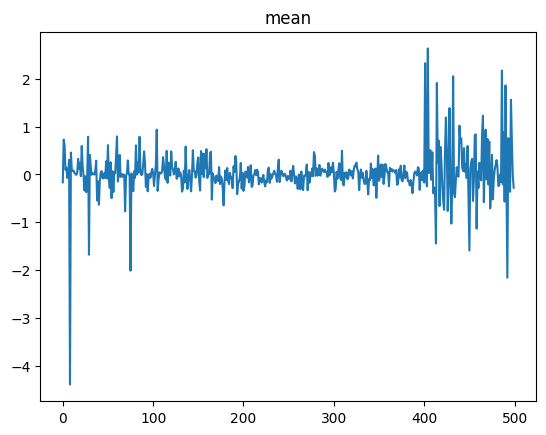

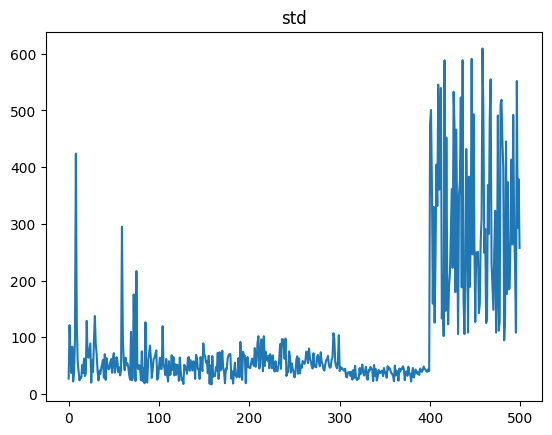

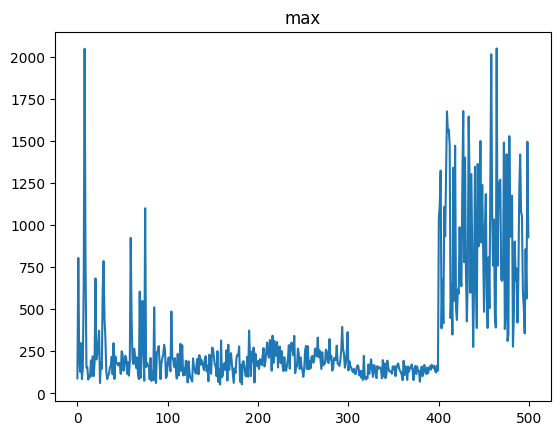

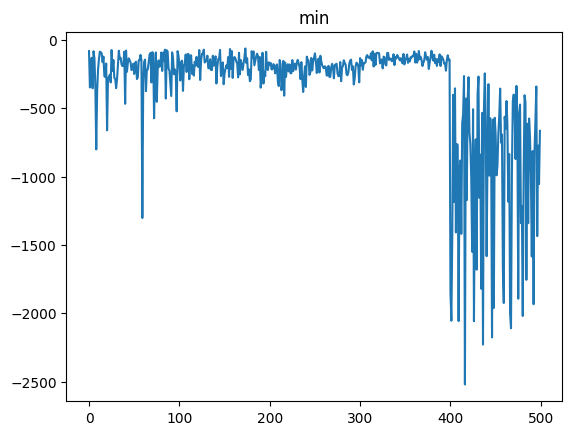

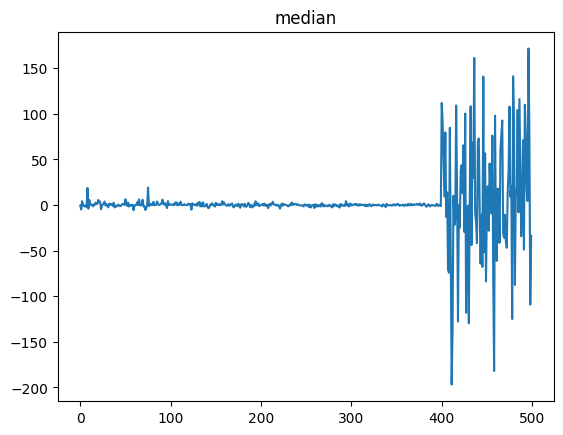

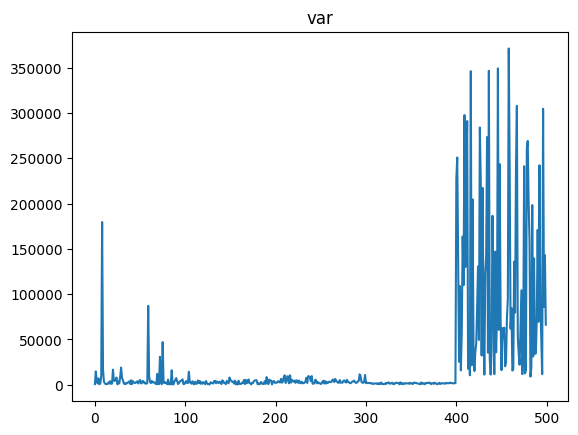

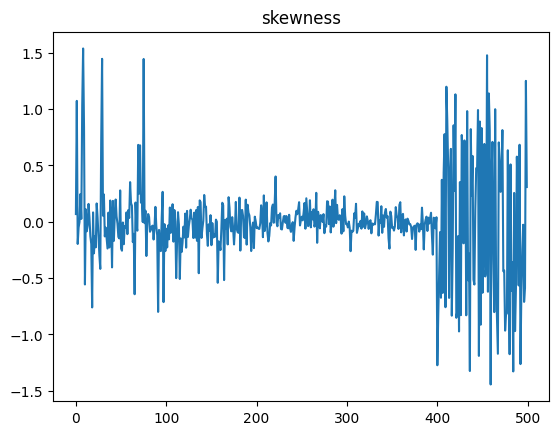

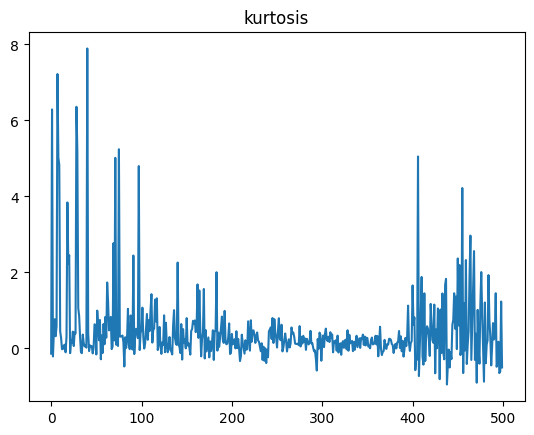

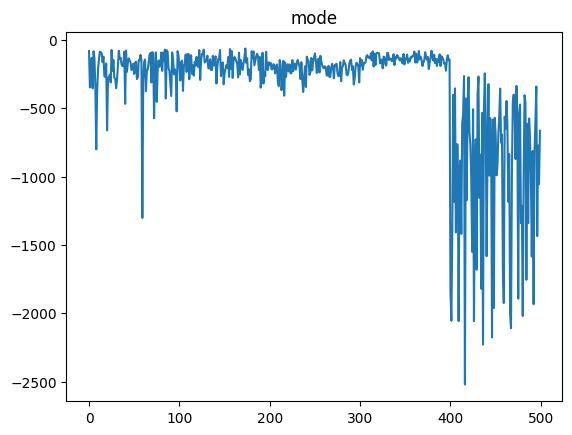

In [163]:
# Statistical features: mean, std, max, min, median, variance, skewness, kurtosis, mode;
mean = np.mean(x, axis=1)
plot(mean, 'mean')

std = np.std(x, axis=1)
plot(std, 'std')

max = np.max(x, axis=1)
plot(max, 'max')

min = np.min(x, axis=1)
plot(min, 'min')

median = np.median(x, axis=1)
plot(median, 'median')

var = np.var(x, axis=1)
plot(var, 'var')

skewness = st.skew(x, axis=1)
plot(skewness, 'skewness')

kurtosis = st.kurtosis(x, axis=1)
plot(kurtosis, 'kurtosis')

# the output of mode is exactly like the min of our data, so we ignore it.
mode = []
for row in x:
    mode.append(st.mode(row, keepdims=True)[0][0])
mode = np.array(mode)
plot(mode, 'mode')

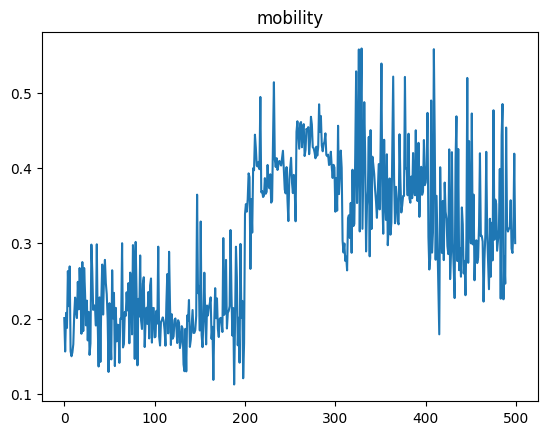

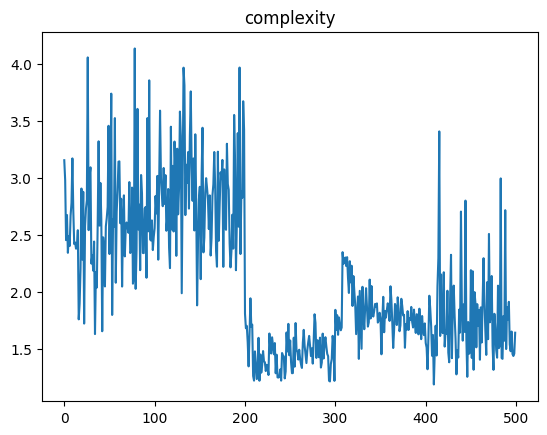

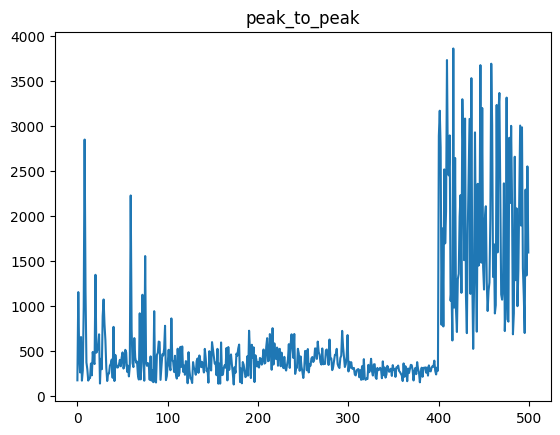

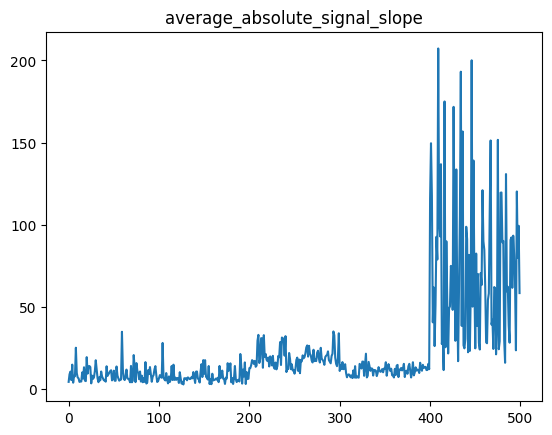

In [164]:
# Time domain features: mobility, complexity, average absolute signal slope, peak-to-peak
def hjorth_params(x, axis=-1):
    x = np.asarray(x)
    # Calculate derivatives
    dx = np.diff(x, axis=axis)
    ddx = np.diff(dx, axis=axis)
    # Calculate variance
    x_var = np.var(x, axis=axis)  # = activity
    dx_var = np.var(dx, axis=axis)
    ddx_var = np.var(ddx, axis=axis)
    # Mobility and complexity
    mob = np.sqrt(dx_var / x_var)
    com = np.sqrt(ddx_var / dx_var) / mob
    return mob, com

mobility, complexity = hjorth_params(x)
plot(mobility, 'mobility')
plot(complexity, 'complexity')


peak_to_peak = np.ptp(x, axis=1)
plot(peak_to_peak, 'peak_to_peak')

average_absolute_signal_slope = np.mean(np.abs(np.diff(x, axis=1)), axis=1)
plot(average_absolute_signal_slope, 'average_absolute_signal_slope')


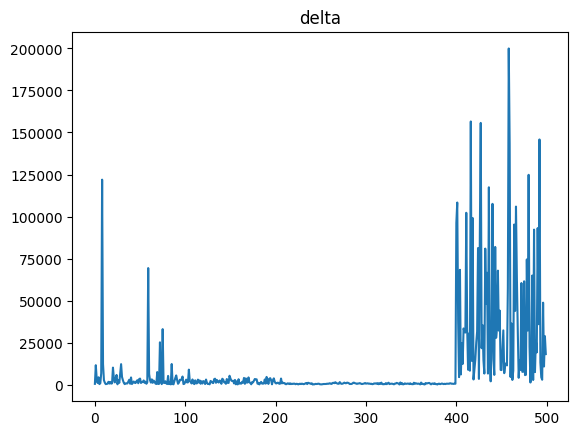

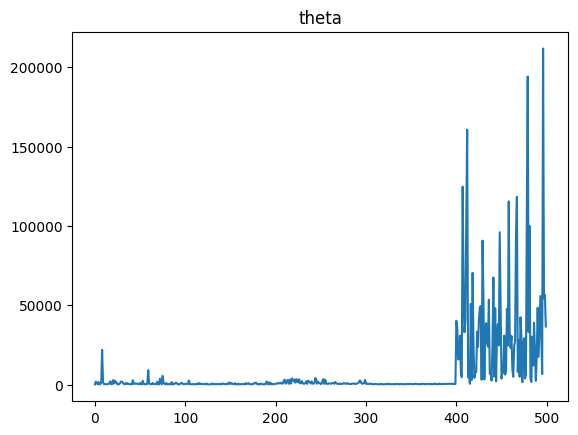

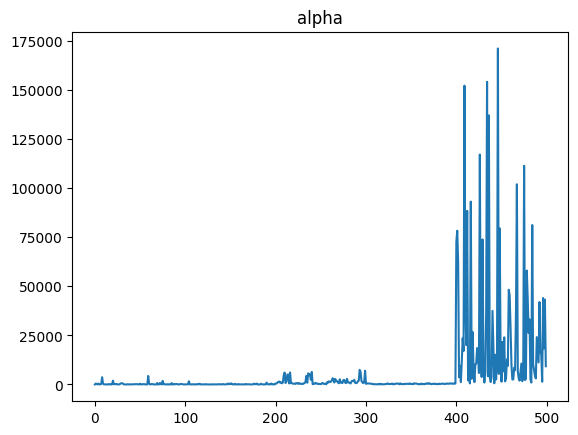

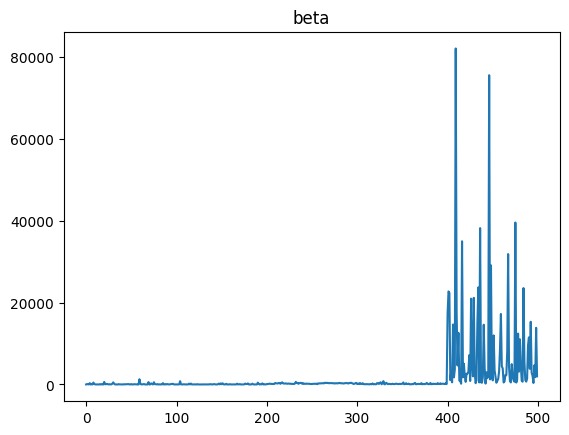

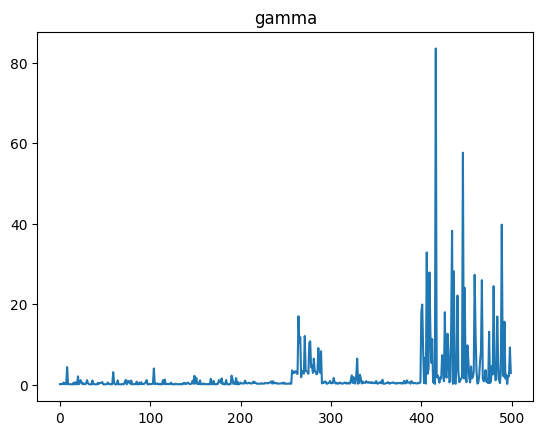

In [165]:
# Frequency domain features: Delta, Theta, Alpha, Beta, Gamma
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If window_sec=None, window_sec = (1 / min(band)) * 2
    relative : bool
        If relative is True, return the relative power (= divided by the total power of the signal).
    Returns
    -------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps

    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

delta = []
theta = []
alpha = []
beta = []
gamma = []

for row in x:
    delta.append(bandpower(row, 128, [0.5, 4], 4))
    theta.append(bandpower(row, 128, [4, 8], 4))
    alpha.append(bandpower(row, 128, [8, 13], 4))
    beta.append(bandpower(row, 128, [13, 30], 4))
    gamma.append(bandpower(row, 128, [30, 50], 4))
delta = np.array(delta)
theta = np.array(theta)
alpha = np.array(alpha)
beta = np.array(beta)
gamma = np.array(gamma)
plot(delta, 'delta')
plot(theta, 'theta')
plot(alpha, 'alpha')
plot(beta, 'beta')
plot(gamma, 'gamma')

(500, 17)


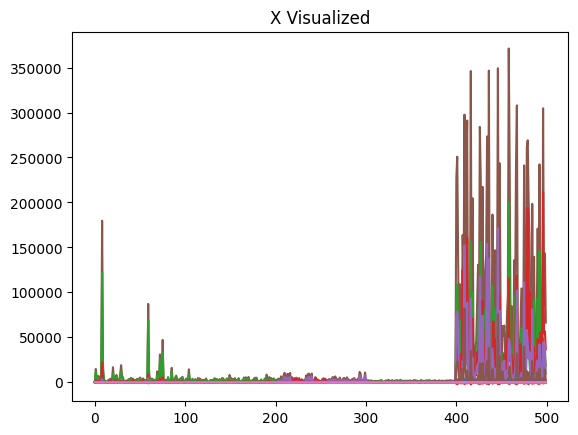

In [166]:
# Reducing data dimensions using extracted features
x_visualized = np.array([mean, std, max, min, median, var, skewness, kurtosis, mobility, complexity, peak_to_peak, average_absolute_signal_slope, delta, theta, alpha, beta, gamma])
x_visualized = x_visualized.T
print(x_visualized.shape)
plot(x_visualized, 'X Visualized')

In [167]:
####################### Classification #######################

In [168]:
# using train_test_split to split data into train and test
xx_train, xx_test, yy_train, yy_test = train_test_split(x,y,random_state=seed,test_size=0.2)
print(xx_train.shape)
print(xx_test.shape)

(400, 4097)
(100, 4097)


In [169]:
# using train_test_split to split visualized data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_visualized,y,random_state=seed,test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(400, 17)
(100, 17)


In [170]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

kf = KFold(n_splits=5, random_state=seed, shuffle=True)

def cross_validation(clf, x, y):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
    }
    scores = cross_validate(clf, x, y, cv=kf, scoring=scoring)
    print(scores)
    print('Accuracy: ', np.mean(scores['test_accuracy']))
    print('Recall: ', np.mean(scores['test_recall']))
    print('Precision: ', np.mean(scores['test_precision']))

In [171]:
# using SVM

In [172]:
# svm with linear kernel that used of train_test_split for splitting data
linear_svm_clf = SVC(kernel='linear')
linear_svm_clf.fit(xx_train, yy_train)
svm_y_pred = linear_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.87
Recall:  0.5
Precision:  1.0


In [173]:
# svm with linear kernel that used of train_test_split for splitting visualized data
linear_svm_clf.fit(x_train, y_train)
svm_y_pred = linear_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.96
Recall:  0.8461538461538461
Precision:  1.0


In [174]:
# svm with linear kernel that used of cross validation(k_fold) for splitting data
cross_validation(linear_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.19847083, 0.26632333, 0.21139693, 0.18753815, 0.30817294]), 'score_time': array([0.04491591, 0.04388452, 0.03091717, 0.0428462 , 0.07879019]), 'test_accuracy': array([0.87, 0.89, 0.86, 0.93, 0.88]), 'test_recall': array([0.5       , 0.38888889, 0.39130435, 0.5       , 0.36842105]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.8860000000000001
Recall:  0.4297228578693109
Precision:  1.0


In [175]:
# svm with linear kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(linear_svm_clf, x_visualized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([32.73548007, 25.73416066, 31.79096341, 47.00602102, 31.96447825]), 'score_time': array([0.00499082, 0.00498676, 0.00398993, 0.0050261 , 0.00598478]), 'test_accuracy': array([0.96, 0.98, 1.  , 0.99, 0.99]), 'test_recall': array([0.84615385, 0.94444444, 1.        , 1.        , 1.        ]), 'test_precision': array([1.        , 0.94444444, 1.        , 0.93333333, 0.95      ])}
Accuracy:  0.984
Recall:  0.958119658119658
Precision:  0.9655555555555557


In [176]:
# svm with rbf kernel that used of train_test_split for splitting data
rbf_svm_clf = SVC(kernel='rbf')
rbf_svm_clf.fit(xx_train, yy_train)
svm_y_pred = rbf_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

Accuracy:  0.96
Recall:  0.8846153846153846
Precision:  0.9583333333333334


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [177]:
# svm with rbf kernel that used of train_test_split for splitting visualized data
rbf_svm_clf.fit(x_train, y_train)
svm_y_pred = rbf_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.95
Recall:  0.8461538461538461
Precision:  0.9565217391304348


In [178]:
# svm with rbf kernel that used of cross validation(k_fold) for splitting data
cross_validation(rbf_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.10971045, 0.09378767, 0.10771036, 0.07978606, 0.09175491]), 'score_time': array([0.03091264, 0.03088045, 0.0339098 , 0.02692723, 0.02892232]), 'test_accuracy': array([0.96, 0.96, 0.98, 0.95, 0.96]), 'test_recall': array([0.88461538, 0.77777778, 0.91304348, 0.78571429, 0.78947368]), 'test_precision': array([0.95833333, 1.        , 1.        , 0.84615385, 1.        ])}
Accuracy:  0.962
Recall:  0.8301249221157688
Precision:  0.9608974358974359


In [179]:
# svm with rbf kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(rbf_svm_clf, x_visualized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.00494647, 0.00299191, 0.00298643, 0.00399017, 0.00299191]), 'score_time': array([0.00598574, 0.00801754, 0.00498724, 0.00698042, 0.00793886]), 'test_accuracy': array([0.95, 0.95, 0.99, 0.95, 0.95]), 'test_recall': array([0.84615385, 0.77777778, 0.95652174, 0.78571429, 0.73684211]), 'test_precision': array([0.95652174, 0.93333333, 1.        , 0.84615385, 1.        ])}
Accuracy:  0.958
Recall:  0.8206019508079004
Precision:  0.9472017837235228


In [180]:
# svm with poly kernel that used of train_test_split for splitting data
poly_svm_clf = SVC(kernel='poly')
poly_svm_clf.fit(xx_train, yy_train)
svm_y_pred = poly_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8
Recall:  0.23076923076923078
Precision:  1.0


In [181]:
# svm with poly kernel that used of train_test_split for splitting visualized data
poly_svm_clf.fit(x_train, y_train)
svm_y_pred = poly_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

Accuracy:  0.88
Recall:  0.5769230769230769
Precision:  0.9375


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [182]:
# svm with poly kernel that used of cross validation(k_fold) for splitting data
cross_validation(poly_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.29325509, 0.27127814, 0.27390218, 0.26828384, 0.25232601]), 'score_time': array([0.06083608, 0.05684447, 0.05684757, 0.05385685, 0.05185795]), 'test_accuracy': array([0.8 , 0.84, 0.79, 0.9 , 0.85]), 'test_recall': array([0.23076923, 0.11111111, 0.08695652, 0.28571429, 0.21052632]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.836
Recall:  0.18501549302464632
Precision:  1.0


In [183]:
# svm with poly kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(poly_svm_clf, x_visualized, y)

{'fit_time': array([0.00398755, 0.00299168, 0.00295305, 0.00299001, 0.00398922]), 'score_time': array([0.00798798, 0.0050261 , 0.00702   , 0.00498843, 0.00502634]), 'test_accuracy': array([0.88, 0.91, 0.94, 0.94, 0.93]), 'test_recall': array([0.57692308, 0.5       , 0.73913043, 0.57142857, 0.63157895]), 'test_precision': array([0.9375, 1.    , 1.    , 1.    , 1.    ])}
Accuracy:  0.9199999999999999
Recall:  0.6038122061005357
Precision:  0.9875


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [184]:
# svm with sigmoid kernel that used of train_test_split for splitting data
sigmoid_svm_clf = SVC(kernel='sigmoid')
sigmoid_svm_clf.fit(xx_train, yy_train)
svm_y_pred = sigmoid_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8
Recall:  0.23076923076923078
Precision:  1.0


In [185]:
# svm with sigmoid kernel that used of train_test_split for splitting visualized data
sigmoid_svm_clf.fit(x_train, y_train)
svm_y_pred = sigmoid_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

Accuracy:  0.9
Recall:  0.8076923076923077
Precision:  0.8076923076923077


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [186]:
# svm with sigmoid kernel that used of cross validation(k_fold) for splitting data;
cross_validation(sigmoid_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.18649769, 0.19052267, 0.18048   , 0.18649626, 0.2153852 ]), 'score_time': array([0.03391671, 0.03391385, 0.03095412, 0.03686762, 0.03291154]), 'test_accuracy': array([0.8 , 0.84, 0.82, 0.87, 0.86]), 'test_recall': array([0.23076923, 0.11111111, 0.2173913 , 0.14285714, 0.26315789]), 'test_precision': array([1.        , 1.        , 1.        , 0.66666667, 1.        ])}
Accuracy:  0.8380000000000001
Recall:  0.19305733676443054
Precision:  0.9333333333333332


In [187]:
# svm with sigmoid kernel that used of cross validation(k_fold) for splitting data;
cross_validation(sigmoid_svm_clf, x_visualized, y)

{'fit_time': array([0.00398898, 0.00399017, 0.00295162, 0.0029912 , 0.00399065]), 'score_time': array([0.00598788, 0.00602698, 0.00598454, 0.00498676, 0.00498533]), 'test_accuracy': array([0.9 , 0.95, 0.98, 0.94, 0.95]), 'test_recall': array([0.80769231, 0.72222222, 0.91304348, 0.71428571, 0.73684211]), 'test_precision': array([0.80769231, 1.        , 1.        , 0.83333333, 1.        ])}
Accuracy:  0.944
Recall:  0.7788171655448544
Precision:  0.9282051282051281


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [188]:
# using Random Forest

In [189]:
# random forest that used of train_test_split for splitting data
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=seed)
random_forest_clf.fit(xx_train, yy_train)
random_forest_y_pred = random_forest_clf.predict(xx_test)
evaluation(yy_test,random_forest_y_pred)

C:\Users\KASRA\AppData\Local\Temp\ipykernel_10776\3153351049.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(xx_train, yy_train)


Accuracy:  0.92
Recall:  0.6923076923076923
Precision:  1.0


In [190]:
# random forest that used of train_test_split for splitting visualized data
random_forest_clf.fit(x_train, y_train)
random_forest_y_pred = random_forest_clf.predict(x_test)
evaluation(y_test,random_forest_y_pred)

C:\Users\KASRA\AppData\Local\Temp\ipykernel_10776\2061175495.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train, y_train)


Accuracy:  0.98
Recall:  0.9615384615384616
Precision:  0.9615384615384616


In [198]:
# random forest that used of cross validation(k_fold) for splitting data;
cross_validation(random_forest_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Py

{'fit_time': array([0.91156006, 1.03323317, 0.98839521, 0.96147251, 0.91252327]), 'score_time': array([0.02892447, 0.02892375, 0.0318749 , 0.0259397 , 0.02498031]), 'test_accuracy': array([0.91, 0.93, 0.95, 0.95, 0.92]), 'test_recall': array([0.65384615, 0.61111111, 0.7826087 , 0.64285714, 0.57894737]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.932
Recall:  0.6538740943775269
Precision:  1.0


In [197]:
# random forest that used of cross validation(k_fold) for splitting visualized data;
cross_validation(random_forest_clf, x_visualized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Py

{'fit_time': array([0.34208727, 0.33714104, 0.36303067, 0.36659336, 0.36139917]), 'score_time': array([0.02393484, 0.02393913, 0.02293634, 0.02489662, 0.02688122]), 'test_accuracy': array([0.98, 0.96, 1.  , 0.98, 0.98]), 'test_recall': array([0.96153846, 0.83333333, 1.        , 1.        , 0.94736842]), 'test_precision': array([0.96153846, 0.9375    , 1.        , 0.875     , 0.94736842])}
Accuracy:  0.9800000000000001
Recall:  0.9484480431848853
Precision:  0.9442813765182188


In [191]:
# using KNN

In [192]:
# knn that used of train_test_split for splitting data
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(xx_train, yy_train)
knn_y_pred = knn_clf.predict(xx_test)
evaluation(yy_test,knn_y_pred)

Accuracy:  0.78
Recall:  0.15384615384615385
Precision:  1.0


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [193]:
# knn that used of train_test_split for splitting visualized data
knn_clf.fit(x_train, y_train)
knn_y_pred = knn_clf.predict(x_test)
evaluation(y_test,knn_y_pred)

Accuracy:  0.95
Recall:  0.8461538461538461
Precision:  0.9565217391304348


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# knn that used of cross validation(k_fold) for splitting data;
cross_validation(knn_clf, x, y)

In [ ]:
# knn that used of cross validation(k_fold) for splitting visualized data;
cross_validation(knn_clf, x_visualized, y)

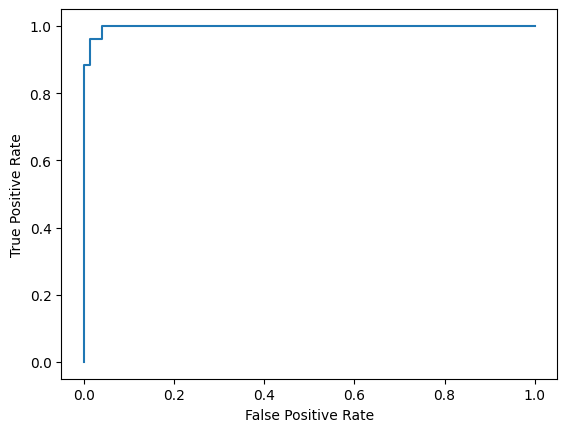

In [194]:
# Drawing ROC curve
y_score = random_forest_clf.predict_proba(x_test)[::,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,  y_score)
auc = roc_auc_score(y_test, y_score)
plt.plot(false_positive_rate,true_positive_rate,label="auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

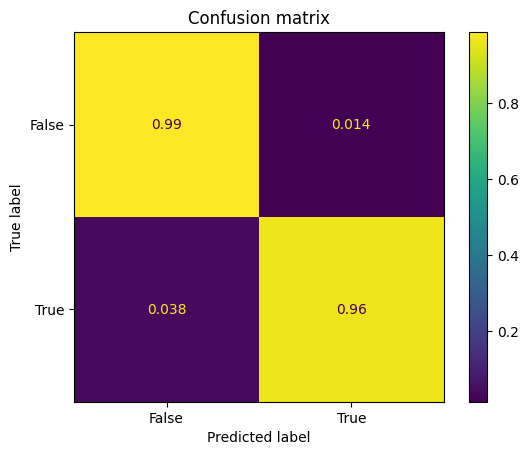

In [195]:
# Drawing confusion matrix
cm = confusion_matrix(y_test, random_forest_y_pred, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()